In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from typing import Sequence, Tuple
import pandas as pd
from collections import OrderedDict, defaultdict
import torch.nn.functional as F

model_equations = []

def fed_model(testimages):
    # Load the Iris dataset
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Number of clients
    n_clients = 3

    # Split the training data into n_clients parts
    indices = np.arange(len(train_dataset))
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, n_clients)

    # Create data loaders for each client
    client_loaders = []
    batch_size = 16
    for client_indices in split_indices:
        client_subset = Subset(train_dataset, client_indices)
        client_loader = DataLoader(client_subset, batch_size=batch_size, shuffle=True)
        client_loaders.append(client_loader)

    # Define a simple feedforward neural network model
    class SimpleNN(nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(4, 50)  # Adjust input size to match the number of features (4 for Iris)
            self.fc2 = nn.Linear(50, 20)
            self.fc3 = nn.Linear(20, 3)  # Adjust output size to match the number of classes (3 for Iris)
            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Train the model on each client's data and save the weights
    client_models = []
    epochs = 20
    criterion = nn.CrossEntropyLoss()

    for i, loader in enumerate(client_loaders):
        model = SimpleNN()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        # Training loop
        for epoch in range(epochs):
            running_loss = 0.0
            for inputs, labels in loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            # print(f'Client {i+1}, Epoch {epoch+1}, Loss: {running_loss / len(loader)}')

        # Save the model weights
        torch.save(model.state_dict(), f'client_{i+1}_model.pth')
        client_models.append(model.state_dict())

    # Federated averaging
    sums = defaultdict(int)
    count = len(client_models)
    for od in client_models:
        for key, value in od.items():
            sums[key] += value

    # Calculate the average for each key
    averages = {key: value / count for key, value in sums.items()}

    # Convert the averages to an OrderedDict (optional)
    average_ordereddict = OrderedDict(averages)

    model = SimpleNN()
    model.load_state_dict(average_ordereddict)
    testimages = torch.tensor(testimages, dtype=torch.float32)
    y_test = model(testimages)
    return y_test

# Configuration class
class Config:
    def __init__(self, dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32):
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size

# Base Model class (assuming you have this implemented)
class Model(nn.Module):
    def __init__(self, config, name):
        super(Model, self).__init__()
        self.config = config
        self.name = name

# FeatureNN class (assuming you have this implemented)
class FeatureNN(nn.Module):
    def __init__(self, config, name, input_shape, num_units, feature_num):
        super(FeatureNN, self).__init__()
        self.config = config
        self.name = name
        self.input_shape = input_shape
        self.num_units = num_units
        self.feature_num = feature_num
        self.fc = nn.Linear(input_shape, num_units)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        return x

# NAM model definition
class NAM(Model):
    def __init__(self, config, name, *, num_inputs: int, num_units: int) -> None:
        super(NAM, self).__init__(config, name)
        self._num_inputs = num_inputs
        self.dropout = nn.Dropout(p=self.config.dropout)

        if isinstance(num_units, list):
            assert len(num_units) == num_inputs
            self._num_units = num_units
        elif isinstance(num_units, int):
            self._num_units = [num_units for _ in range(self._num_inputs)]

        self.feature_nns = nn.ModuleList([
            FeatureNN(config=config, name=f'FeatureNN_{i}', input_shape=1, num_units=self._num_units[i], feature_num=i)
            for i in range(num_inputs)
        ])

        self.output_layer = nn.Linear(sum(self._num_units), 3)  # 3 classes for Iris dataset
        self._bias = torch.nn.Parameter(data=torch.zeros(1))

    def calc_outputs(self, inputs: torch.Tensor) -> Sequence[torch.Tensor]:
        return [self.feature_nns[i](inputs[:, i:i+1]) for i in range(self._num_inputs)]

    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        individual_outputs = self.calc_outputs(inputs)
        conc_out = torch.cat(individual_outputs, dim=-1)
        dropout_out = self.dropout(conc_out)
        out = self.output_layer(dropout_out)
        return out, dropout_out

    def print_model_equation(self, feature_names):
        equation_terms = []
        feature_contributions = {}
        for i, fnn in enumerate(self.feature_nns):
            coefficients = fnn.fc.weight.data.flatten().tolist()
            intercepts = fnn.fc.bias.data.tolist()
            term = " + ".join([f"({coeff:.3f} * x_{feature_names[i]} + {intercept:.3f})" for coeff, intercept in zip(coefficients, intercepts)])
            equation_terms.append(term)
            feature_contributions[feature_names[i]] = sum(abs(c) for c in coefficients)
        equation = " + ".join(equation_terms) + f" + bias ({self._bias.item():.3f})"
        print(f"Model Equation: y = {equation}")
        model_equations.append(equation)
        interpretability = sorted(feature_contributions.items(), key=lambda x: x[1], reverse=True)
        print("\nFeature Contributions:")
        for feature, contribution in interpretability:
            print(f"{feature}: {contribution:.3f}")
        return interpretability[0][0]

n_clients = 3
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_columns = iris.feature_names

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into n_clients
indices = np.arange(len(X))
np.random.shuffle(indices)
split_indices = np.array_split(indices, n_clients)
client_data = [(X[indices], y[indices]) for indices in split_indices]

for i in range(n_clients):
    X, y = client_data[i]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Define the config
    config = Config(dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32)

    # Instantiate the NAM model
    num_inputs = len(feature_columns)  # Number of features
    num_units = 10  # Number of units in the hidden layer
    nam_model = NAM(config=config, name='NAM_Model', num_inputs=num_inputs, num_units=num_units)

    # Training function
    def train(model, X_train, y_train, config):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        model.train()
        for epoch in range(config.num_epochs):
            outputs = fed_model(X_test_tensor)
            optimizer.zero_grad()
            loss = criterion(outputs, y_test_tensor)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {loss.item():.4f}')
        return model

    # Evaluation function
    def evaluate(model, X_test, y_test):
        model.eval()
        with torch.no_grad():
            outputs, _ = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_test).sum().item() / y_test.size(0)
            print(f'Accuracy: {accuracy * 100:.2f}%')

    # Train the model
    trained_model = train(nam_model, X_train_tensor, y_train_tensor, config)

    # Evaluate the model
    evaluate(trained_model, X_test_tensor, y_test_tensor)

    # Print the model equation and get the most contributing feature
    most_contributing_feature = trained_model.print_model_equation(feature_columns)
    print(f"\nMost contributing feature for client's output {i}: {most_contributing_feature}")


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [10/50], Loss: 0.8686


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [20/50], Loss: 0.9159


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [30/50], Loss: 0.8916


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [40/50], Loss: 1.0348


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [50/50], Loss: 0.9059
Accuracy: 46.67%
Model Equation: y = (0.587 * x_sepal length (cm) + -0.285) + (0.981 * x_sepal length (cm) + -0.882) + (0.773 * x_sepal length (cm) + 0.885) + (-0.389 * x_sepal length (cm) + -0.853) + (0.375 * x_sepal length (cm) + 0.297) + (-0.649 * x_sepal length (cm) + 0.407) + (-0.410 * x_sepal length (cm) + -0.526) + (-0.486 * x_sepal length (cm) + -0.513) + (-0.112 * x_sepal length (cm) + -0.569) + (0.090 * x_sepal length (cm) + 0.815) + (-0.314 * x_sepal width (cm) + 0.756) + (-0.567 * x_sepal width (cm) + 0.083) + (0.322 * x_sepal width (cm) + 0.529) + (-0.660 * x_sepal width (cm) + -0.466) + (-0.000 * x_sepal width (cm) + -0.048) + (-0.100 * x_sepal width (cm) + -0.880) + (0.939 * x_sepal width (cm) + 0.814) + (-0.392 * x_sepal width (cm) + 0.129) + (0.768 * x_sepal width (cm) + -0.147) + (0.630 * x_sepal width (cm) + 0.214) + (0.538 * x_petal length (cm) + -0.438) + (-0.333 * x_petal length (cm) + 0.744) + (-0.039 * x_petal length (cm) + -0.384) + 

<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [10/50], Loss: 0.8968


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [20/50], Loss: 0.9791


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [30/50], Loss: 0.8767


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [40/50], Loss: 0.9265


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [50/50], Loss: 1.0589
Accuracy: 26.67%
Model Equation: y = (-0.299 * x_sepal length (cm) + -0.883) + (0.055 * x_sepal length (cm) + 0.163) + (0.583 * x_sepal length (cm) + 0.184) + (-0.205 * x_sepal length (cm) + -0.560) + (-0.918 * x_sepal length (cm) + 0.860) + (0.712 * x_sepal length (cm) + -0.658) + (-0.904 * x_sepal length (cm) + 0.242) + (0.489 * x_sepal length (cm) + -0.328) + (-0.016 * x_sepal length (cm) + 0.277) + (-0.042 * x_sepal length (cm) + -0.494) + (-0.537 * x_sepal width (cm) + 0.071) + (0.815 * x_sepal width (cm) + 0.467) + (-0.208 * x_sepal width (cm) + 0.456) + (0.913 * x_sepal width (cm) + 0.212) + (-0.790 * x_sepal width (cm) + 0.791) + (-0.428 * x_sepal width (cm) + -0.909) + (0.115 * x_sepal width (cm) + -0.258) + (0.050 * x_sepal width (cm) + -0.237) + (-0.394 * x_sepal width (cm) + -0.523) + (0.109 * x_sepal width (cm) + -0.343) + (-0.983 * x_petal length (cm) + -0.822) + (-0.236 * x_petal length (cm) + 0.778) + (-0.250 * x_petal length (cm) + -0.702) +

<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [10/50], Loss: 0.8646


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [20/50], Loss: 0.8923


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [30/50], Loss: 0.9240


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [40/50], Loss: 0.9858


<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)
<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

Epoch [50/50], Loss: 0.9745
Accuracy: 40.00%
Model Equation: y = (0.408 * x_sepal length (cm) + 0.164) + (-0.999 * x_sepal length (cm) + -0.398) + (0.533 * x_sepal length (cm) + 0.796) + (0.619 * x_sepal length (cm) + 0.618) + (-0.569 * x_sepal length (cm) + 0.602) + (0.821 * x_sepal length (cm) + 0.516) + (0.045 * x_sepal length (cm) + 0.224) + (0.659 * x_sepal length (cm) + 0.568) + (-0.693 * x_sepal length (cm) + -0.975) + (0.849 * x_sepal length (cm) + -0.889) + (0.112 * x_sepal width (cm) + -0.700) + (-0.943 * x_sepal width (cm) + -0.619) + (-0.164 * x_sepal width (cm) + -0.252) + (0.068 * x_sepal width (cm) + -0.515) + (-0.168 * x_sepal width (cm) + 0.360) + (0.185 * x_sepal width (cm) + 0.142) + (-0.968 * x_sepal width (cm) + -0.048) + (-0.073 * x_sepal width (cm) + 0.429) + (0.552 * x_sepal width (cm) + 0.435) + (-0.583 * x_sepal width (cm) + -0.701) + (0.950 * x_petal length (cm) + 0.440) + (0.909 * x_petal length (cm) + -0.851) + (-0.836 * x_petal length (cm) + -0.056) + (0.6

<ipython-input-1-e162dc89bfec>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testimages = torch.tensor(testimages, dtype=torch.float32)


KeyError: 'Sepal_length'

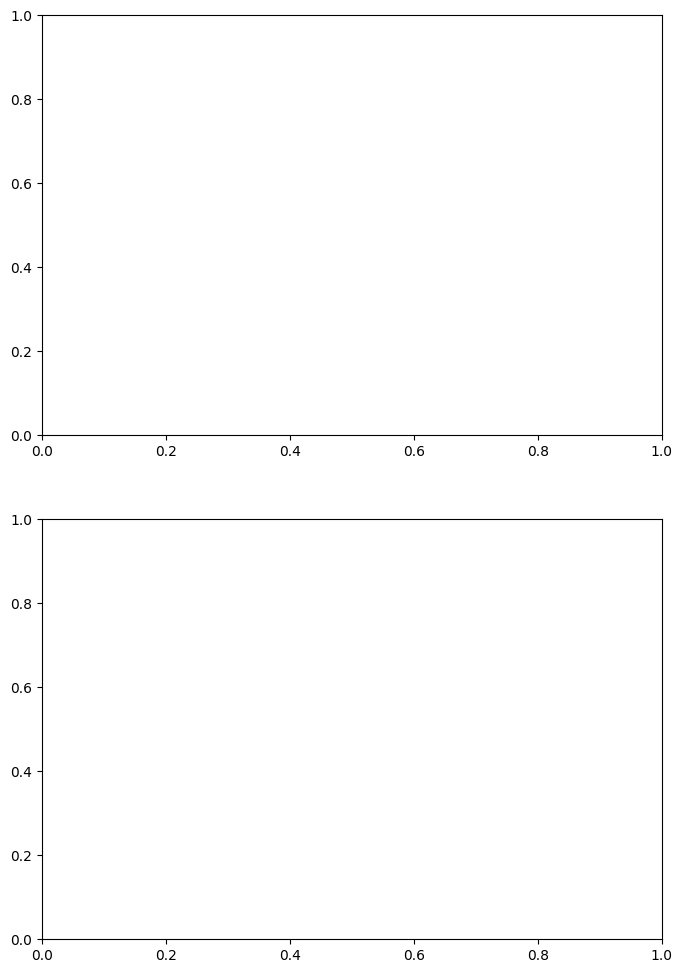

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Given coefficients and intercepts for each feature
coefficients_client1 = {
    "x_sepal_length": [0.408, -0.999, 0.533, 0.619, -0.569, 0.821, 0.045, 0.659, -0.693, 0.849],
    "x_sepal_width": [0.112, -0.943, -0.164, 0.068, -0.168, 0.185, -0.968, -0.073, 0.552, -0.583],
    "x_petal_length": [0.950, 0.909, -0.836, 0.649, -0.609, -0.775, -0.046, -0.255, -0.985, -0.436],
    "x_petal_width": [-0.092, 0.445, 0.351, 0.710, 0.864, 0.961, -0.886, 0.473, 0.119, 0.409]
}
coefficients_client2 = {
    "x_sepal_length": [0.379, -0.387, 0.728, -0.480, 0.673, -0.348, 0.105, 0.090, 0.287, -0.419],
    "x_sepal_width": [0.961, 0.592, 0.073, 0.367, -0.428, -0.797, 0.333, -0.657, -0.363, -0.585],
    "x_petal_length": [-0.045, 0.077, 0.816, -0.371, -0.652, 0.562, -0.891, 0.651, 0.226, 0.746],
    "x_petal_width": [0.497, -0.384, -0.838, 0.629, -0.924, 0.199, 0.988, -0.690, -0.812, 0.363]
}

intercepts_client2 = {
    "x_sepal_length": [0.686, -0.554, 0.455, -0.706, 0.145, -0.659, 0.500, 0.269, 0.576, -0.608],
    "x_sepal_width": [-0.450, -0.219, -0.689, 0.776, -0.851, -0.281, 0.823, 0.846, -0.716, -0.356],
    "x_petal_length": [-0.050, -0.362, -0.846, -0.432, -0.259, 0.318, 0.512, 0.476, -0.846, -0.517],
    "x_petal_width": [0.375, 0.929, -0.438, 0.346, -0.039, -0.459, 0.400, -0.240, 0.810, -0.683]
}

coefficients_client3 = {
    "x_sepal_length": [0.664, 0.276, -0.852, 0.570, 0.112, -0.098, -0.506, -0.568, -0.291, -0.233],
    "x_sepal_width": [-0.240, 0.736, 0.087, -0.140, -0.751, -0.256, 0.565, 0.504, -0.364, 0.842],
    "x_petal_length": [-0.181, 0.346, 0.921, -0.579, -0.739, -0.216, -0.465, 0.852, -0.189, 0.058],
    "x_petal_width": [0.839, -0.375, 0.741, 0.070, 0.684, 0.602, -0.397, 0.590, 0.348, -0.923]
}

intercepts_client3 = {
    "x_sepal_length": [-0.752, -0.238, -0.019, 0.910, -0.555, 0.702, 0.895, -0.537, 0.135, 0.329],
    "x_sepal_width": [-0.795, 0.197, 0.684, 0.729, -0.232, 0.162, -0.868, -0.151, 0.818, 0.136],
    "x_petal_length": [-0.623, 0.310, 0.640, -0.165, 0.713, 0.723, -0.086, -0.203, -0.374, 0.069],
    "x_petal_width": [-0.685, -0.317, -0.323, -0.751, 0.567, -0.284, 0.730, 0.472, 0.680, -0.770]
}

intercepts_client1 = {
    "x_sepal_length": [0.164, -0.398, 0.796, 0.618, 0.602, 0.516, 0.224, 0.568, -0.975, -0.889],
    "x_sepal_width": [-0.700, -0.619, -0.252, -0.515, 0.360, 0.142, -0.048, 0.429, 0.435, -0.701],
    "x_petal_length": [0.440, -0.851, -0.056, 0.847, 0.769, -0.382, -0.538, -0.126, -0.718, -0.175],
    "x_petal_width": [0.508, -0.498, 0.796, -0.281, 0.503, 0.990, -0.551, -0.502, 0.500, -0.215]
}


# Function to plot equations for a given range of indices and connect lines
def plot_connected_equations(ax, coefficients, intercepts, feature_name, indices, client_label, color):
    all_x_values = []
    all_y_values = []
    for i, index in enumerate(indices):
        start_x = i * 10
        end_x = start_x + 10
        x_values = np.linspace(start_x, end_x, 100)
        coef = coefficients[feature_name][index]
        intercept = intercepts[feature_name][index]
        y_values = coef * x_values + intercept
        all_x_values.extend(x_values)
        all_y_values.extend(y_values)
    ax.plot(all_x_values, all_y_values, label=client_label, color=color)
    ax.set_xlabel(feature_name)
    ax.set_ylabel('y')
    ax.legend()

# Features to plot
features = ['Sepal_length', 'Sepal_width', 'Petal_length', 'Petal_width']

# Select the 6 best plots (for example, we choose 1, 2, 3, 4, 5, 6)
selected_features_1 = ['Sepal_length', 'Sepal_width']
selected_features_2 = ['Petal_length', 'Petal_width']

# Plot the first set of 2 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
clients = ['Client 1', 'Client 2', 'Client 3']
colors = ['blue', 'green', 'red']
for i, feature in enumerate(selected_features_1):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2], colors[2])
    axs[i].set_title(f'{feature}')
fig.suptitle('', y=0.93, fontsize=40)
plt.tight_layout()
plt.savefig('selected_plots_1_vertical_colored.png')

# Plot the second set of 2 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
for i, feature in enumerate(selected_features_2):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2], colors[2])
    axs[i].set_title(f'{feature}')
fig.suptitle('', y=0.93, fontsize=40)
plt.tight_layout()
plt.savefig('selected_plots_2_vertical_colored.png')

plt.show()


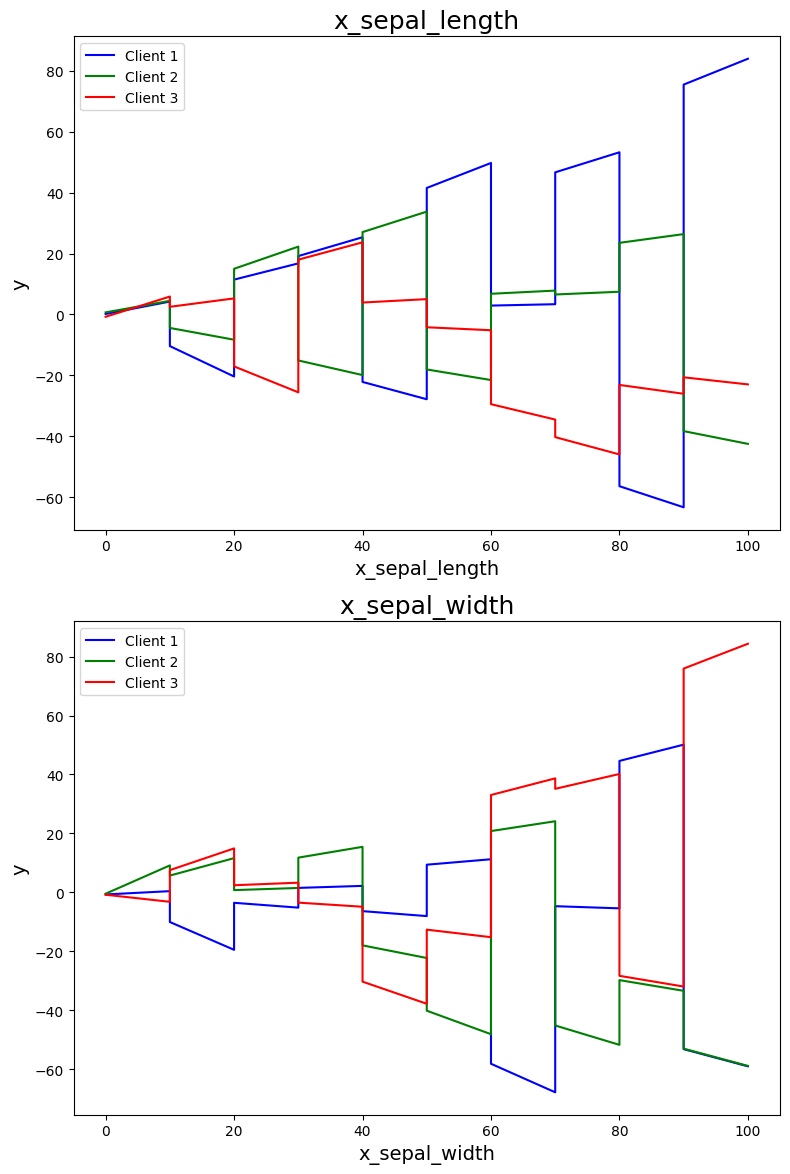

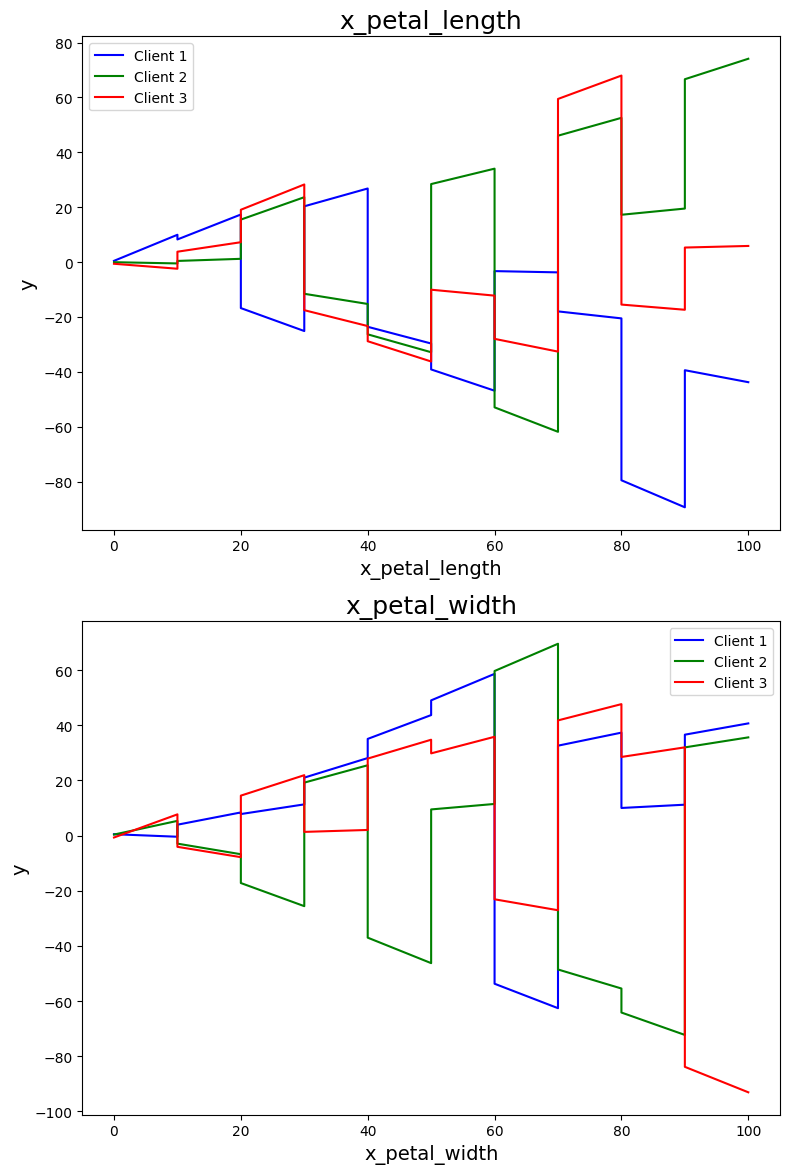

In [ ]:
# Function to plot equations for a given range of indices and connect lines with increased font size
def plot_connected_equations(ax, coefficients, intercepts, feature_name, indices, client_label, color):
    all_x_values = []
    all_y_values = []
    for i, index in enumerate(indices):
        start_x = i * 10
        end_x = start_x + 10
        x_values = np.linspace(start_x, end_x, 100)
        coef = coefficients[feature_name][index]
        intercept = intercepts[feature_name][index]
        y_values = coef * x_values + intercept
        all_x_values.extend(x_values)
        all_y_values.extend(y_values)
    ax.plot(all_x_values, all_y_values, label=client_label, color=color)
    ax.set_xlabel(feature_name, fontsize=14)  # Increased font size for x label
    ax.set_ylabel('y', fontsize=14)  # Increased font size for y label
    ax.legend()

# Features to plot
features = ['x_sepal_length', 'x_sepal_width', 'x_petal_length', 'x_petal_width']

# Select the 6 best plots (for example, we choose 1, 2, 3, 4, 5, 6)
selected_features_1 = ['x_sepal_length', 'x_sepal_width']
selected_features_2 = ['x_petal_length', 'x_petal_width']

# Plot the first set of 2 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
clients = ['Client 1', 'Client 2', 'Client 3']
colors = ['blue', 'green', 'red']
for i, feature in enumerate(selected_features_1):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2], colors[2])
    axs[i].set_title(f'{feature}', fontsize=18)  # Increased font size for title
fig.suptitle('', y=0.93, fontsize=40)
plt.tight_layout()
plt.savefig('selected_plots_1_vertical_colored.png')

# Plot the second set of 2 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
for i, feature in enumerate(selected_features_2):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2], colors[2])
    axs[i].set_title(f'{feature}', fontsize=18)  # Increased font size for title
fig.suptitle('', y=0.93, fontsize=40)
plt.tight_layout()
plt.savefig('selected_plots_2_vertical_colored.png')

plt.show()


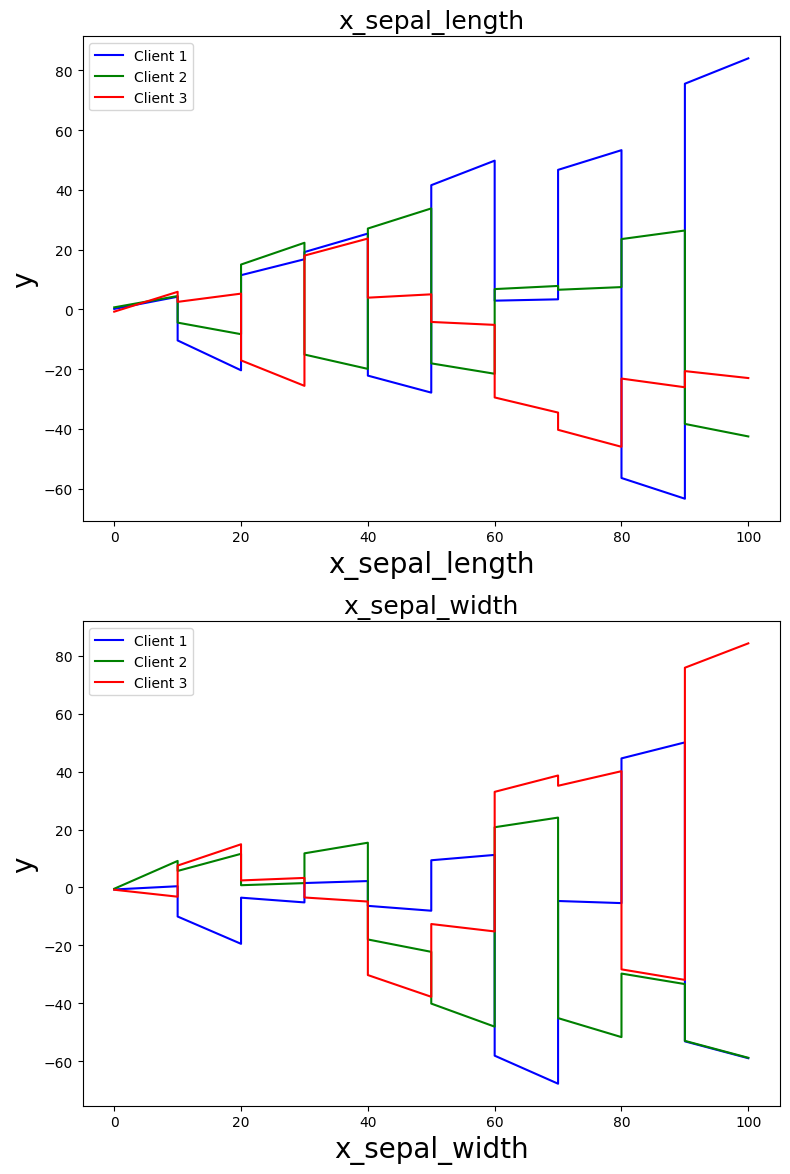

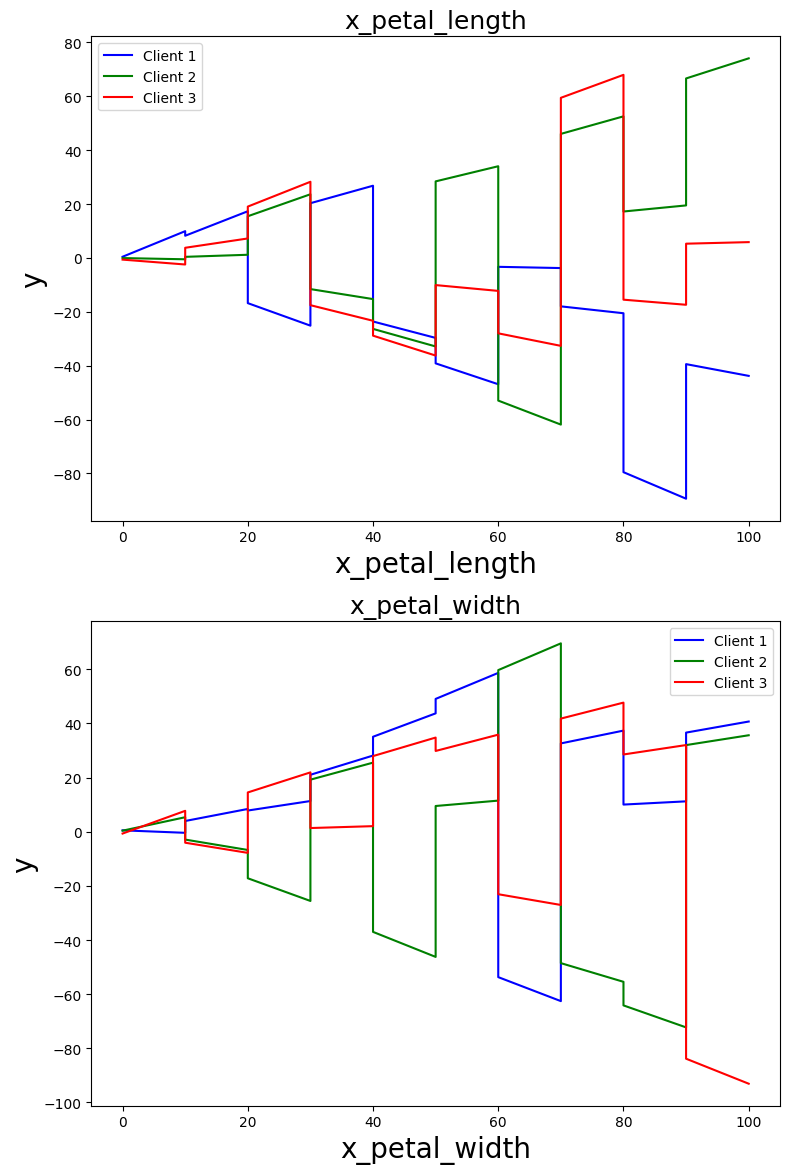

In [ ]:
# Function to plot equations for a given range of indices and connect lines with increased font size
def plot_connected_equations(ax, coefficients, intercepts, feature_name, indices, client_label, color):
    all_x_values = []
    all_y_values = []
    for i, index in enumerate(indices):
        start_x = i * 10
        end_x = start_x + 10
        x_values = np.linspace(start_x, end_x, 100)
        coef = coefficients[feature_name][index]
        intercept = intercepts[feature_name][index]
        y_values = coef * x_values + intercept
        all_x_values.extend(x_values)
        all_y_values.extend(y_values)
    ax.plot(all_x_values, all_y_values, label=client_label, color=color)
    ax.set_xlabel(feature_name, fontsize=20)  # Increased font size for x label
    ax.set_ylabel('y', fontsize=20)  # Increased font size for y label
    ax.legend()

# Features to plot
features = ['x_sepal_length', 'x_sepal_width', 'x_petal_length', 'x_petal_width']

# Select the 6 best plots (for example, we choose 1, 2, 3, 4, 5, 6)
selected_features_1 = ['x_sepal_length', 'x_sepal_width']
selected_features_2 = ['x_petal_length', 'x_petal_width']

# Plot the first set of 2 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
clients = ['Client 1', 'Client 2', 'Client 3']
colors = ['blue', 'green', 'red']
for i, feature in enumerate(selected_features_1):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2], colors[2])
    axs[i].set_title(f'{feature}', fontsize=18)  # Increased font size for title
fig.suptitle('', y=0.93, fontsize=40)
plt.tight_layout()
plt.savefig('selected_plots_1_vertical_colored.png')

# Plot the second set of 2 selected plots vertically, with plots for different clients
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
for i, feature in enumerate(selected_features_2):
    plot_connected_equations(axs[i], coefficients_client1, intercepts_client1, feature, range(10), clients[0], colors[0])
    plot_connected_equations(axs[i], coefficients_client2, intercepts_client2, feature, range(10), clients[1], colors[1])
    plot_connected_equations(axs[i], coefficients_client3, intercepts_client3, feature, range(10), clients[2], colors[2])
    axs[i].set_title(f'{feature}', fontsize=18)  # Increased font size for title
fig.suptitle('', y=0.93, fontsize=40)
plt.tight_layout()
plt.savefig('selected_plots_2_vertical_colored.png')

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from typing import Sequence, Tuple
import pandas as pd
from collections import OrderedDict, defaultdict
import torch.nn.functional as F

model_equations = []

def fed_model(testimages):
    # Load the Iris dataset
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Number of clients
    n_clients = 3

    # Split the training data into n_clients parts
    indices = np.arange(len(train_dataset))
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, n_clients)

    # Create data loaders for each client
    client_loaders = []
    batch_size = 16
    for client_indices in split_indices:
        client_subset = Subset(train_dataset, client_indices)
        client_loader = DataLoader(client_subset, batch_size=batch_size, shuffle=True)
        client_loaders.append(client_loader)

    # Define a simple feedforward neural network model
    class SimpleNN(nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(4, 50)  # Adjust input size to match the number of features (4 for Iris)
            self.fc2 = nn.Linear(50, 20)
            self.fc3 = nn.Linear(20, 3)  # Adjust output size to match the number of classes (3 for Iris)
            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Train the model on each client's data and save the weights
    client_models = []
    epochs = 20
    criterion = nn.CrossEntropyLoss()

    for i, loader in enumerate(client_loaders):
        model = SimpleNN()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        # Training loop
        for epoch in range(epochs):
            running_loss = 0.0
            for inputs, labels in loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            # print(f'Client {i+1}, Epoch {epoch+1}, Loss: {running_loss / len(loader)}')

        # Save the model weights
        torch.save(model.state_dict(), f'client_{i+1}_model.pth')
        client_models.append(model.state_dict())

    # Federated averaging
    sums = defaultdict(int)
    count = len(client_models)
    for od in client_models:
        for key, value in od.items():
            sums[key] += value

    # Calculate the average for each key
    averages = {key: value / count for key, value in sums.items()}

    # Convert the averages to an OrderedDict (optional)
    average_ordereddict = OrderedDict(averages)

    model = SimpleNN()
    model.load_state_dict(average_ordereddict)
    testimages = torch.tensor(testimages, dtype=torch.float32)
    y_test = model(testimages)
    return y_test

# Configuration class
class Config:
    def __init__(self, dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32):
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size

# Base Model class (assuming you have this implemented)
class Model(nn.Module):
    def __init__(self, config, name):
        super(Model, self).__init__()
        self.config = config
        self.name = name

# FeatureNN class (assuming you have this implemented)
class FeatureNN(nn.Module):
    def __init__(self, config, name, input_shape, num_units, feature_num):
        super(FeatureNN, self).__init__()
        self.config = config
        self.name = name
        self.input_shape = input_shape
        self.num_units = num_units
        self.feature_num = feature_num
        self.fc = nn.Linear(input_shape, num_units)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        return x

# NAM model definition
class NAM(Model):
    def __init__(self, config, name, *, num_inputs: int, num_units: int) -> None:
        super(NAM, self).__init__(config, name)
        self._num_inputs = num_inputs
        self.dropout = nn.Dropout(p=self.config.dropout)

        if isinstance(num_units, list):
            assert len(num_units) == num_inputs
            self._num_units = num_units
        elif isinstance(num_units, int):
            self._num_units = [num_units for _ in range(self._num_inputs)]

        self.feature_nns = nn.ModuleList([
            FeatureNN(config=config, name=f'FeatureNN_{i}', input_shape=1, num_units=self._num_units[i], feature_num=i)
            for i in range(num_inputs)
        ])

        self.output_layer = nn.Linear(sum(self._num_units), 3)  # 3 classes for Iris dataset
        self._bias = torch.nn.Parameter(data=torch.zeros(1))

    def calc_outputs(self, inputs: torch.Tensor) -> Sequence[torch.Tensor]:
        return [self.feature_nns[i](inputs[:, i:i+1]) for i in range(self._num_inputs)]

    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        individual_outputs = self.calc_outputs(inputs)
        conc_out = torch.cat(individual_outputs, dim=-1)
        dropout_out = self.dropout(conc_out)
        out = self.output_layer(dropout_out)
        return out, dropout_out

    def print_model_equation(self, feature_names):
        equation_terms = []
        feature_contributions = {}
        for i, fnn in enumerate(self.feature_nns):
            coefficients = fnn.fc.weight.data.flatten().tolist()
            intercepts = fnn.fc.bias.data.tolist()
            term = " + ".join([f"({coeff:.3f} * x_{feature_names[i]} + {intercept:.3f})" for coeff, intercept in zip(coefficients, intercepts)])
            equation_terms.append(term)
            feature_contributions[feature_names[i]] = sum(abs(c) for c in coefficients)
        equation = " + ".join(equation_terms) + f" + bias ({self._bias.item():.3f})"
        print(f"Model Equation: y = {equation}")
        model_equations.append(equation)

        # Determine feature interpretability based on coefficients
        interpretability = sorted(feature_contributions.items(), key=lambda x: x[1], reverse=True)
        print("\nFeature Contributions:")
        for feature, contribution in interpretability:
            print(f"{feature}: {contribution:.3f}")

        return interpretability[0][0]  # Return the feature with the highest contribution

n_clients = 3
# Load Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_columns = iris.feature_names

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into n_clients
indices = np.arange(len(X))
np.random.shuffle(indices)
split_indices = np.array_split(indices, n_clients)
client_data = [(X[indices], y[indices]) for indices in split_indices]

for i in range(n_clients):
    X, y = client_data[i]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Define the config
    config = Config(dropout=0.5, learning_rate=0.001, num_epochs=50, batch_size=32)

    # Instantiate the NAM model
    num_inputs = len(feature_columns)  # Number of features
    num_units = 10  # Number of units in the hidden layer
    nam_model = NAM(config=config, name='NAM_Model', num_inputs=num_inputs, num_units=num_units)

    # Training function
    def train(model, X_train, y_train, config):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        model.train()
        for epoch in range(config.num_epochs):
            outputs = fed_model(X_test_tensor)
            optimizer.zero_grad()
            loss = criterion(outputs, y_test_tensor)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {loss.item():.4f}')
        return model

    # Evaluation function
    def evaluate(model, X_test, y_test):
        model.eval()
        with torch.no_grad():
            outputs, _ = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_test).sum().item() / y_test.size(0)
            print(f'Accuracy: {accuracy * 100:.2f}%')

    # Train the model
    trained_model = train(nam_model, X_train_tensor, y_train_tensor, config)

    # Evaluate the model
    evaluate(trained_model, X_test_tensor, y_test_tensor)

    # Print the model equation and get the most contributing feature
    most_contributing_feature = trained_model.print_model_equation(feature_columns)
    print(f"\nMost contributing feature for client's output {i}: {most_contributing_feature}")
